<a href="https://colab.research.google.com/github/Shashank6278/AI-Based-Early-Paddy-Disease-Detection-Severity-Classification-using-CNN-for-Smart-Farming/blob/main/Final_Research_Paper_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install & Import Librarie**s

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

**Drive mount**

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Load and Preprocess** **Data**

In [ ]:
# Define dataset path in Google Colab
dataset_path = "/content/drive/Shareddrives/Paddy Leaf/Dataset"

# Image Preprocessing & Augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load Training Data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For classification
    shuffle=True,
    subset="training"
)

# Load Validation Data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset="validation"
)

# Class Labels
class_labels = train_generator.class_indices  # {'healthy_leaf': 0, 'leaf_blast': 1, 'sheath_blight': 2, 'brown_spot': 3}


Found 1004 images belonging to 4 classes.
Found 250 images belonging to 4 classes.


**Step 3: Extract Scale Labels**

In [ ]:
import re
import numpy as np

def extract_scale_labels(filenames, labels):
    scale_labels = []

    for i in range(len(labels)):
        if "healthy" in filenames[i]:  # Healthy leaves have no scale
            scale_labels.append(0)
        else:
            # Use regex to find scale number in folder name (handles spaces and different formats)
            match = re.search(r'scale (\d+)', filenames[i])
            if match:
                scale = int(match.group(1))  # Extract the scale value
            else:
                scale = 0  # Default to 0 if no scale is found (should not happen)

            scale_labels.append(scale)

    return np.array(scale_labels, dtype=np.float32)

# Extract scale labels for training and validation
y_train_class = train_generator.classes  # Class labels
y_val_class = val_generator.classes
y_train_scale = extract_scale_labels(train_generator.filenames, train_generator.classes)
y_val_scale = extract_scale_labels(val_generator.filenames, val_generator.classes)



**step 4 Define Multi-Task Learning Model (Function)**

In [ ]:
def build_multi_task_model(pretrained_model):
    # Load Pretrained Model
    base_model = pretrained_model(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze Pretrained Layers

    # Shared Feature Extractor
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Classification Head (4 classes: Healthy, Leaf Blast, Sheath Blight, Brown Spot)
    classification_output = Dense(4, activation="softmax", name="disease_class")(x)

    # Regression Head (Predicts scale 1-9)
    regression_output = Dense(1, activation="linear", name="disease_scale")(x)

    # Create Multi-Task Model
    model = Model(inputs=base_model.input, outputs=[classification_output, regression_output])

    # Compile Model
    model.compile(
        optimizer="adam",
        loss={"disease_class": "categorical_crossentropy", "disease_scale": "mse"},
        metrics={"disease_class": "accuracy", "disease_scale": "mae"}
    )

    return model


Manually Check & Remove Corrupted **Images**

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Define the Custom Data **Generator**

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence

# Custom Multi-Task Data Generator
class MultiTaskDataGenerator(Sequence):
    def __init__(self, image_generator, y_scale):
        self.image_generator = image_generator  # The original ImageDataGenerator
        self.y_scale = y_scale  # Regression labels for scale prediction

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images, y_class = self.image_generator[index]  # Get images and class labels
        batch_size = images.shape[0]

        # Get scale labels for this batch
        y_scale_batch = self.y_scale[index * batch_size : (index + 1) * batch_size]

        return images, {"disease_class": y_class, "disease_scale": y_scale_batch}

# Create new data generators
train_generator_multi = MultiTaskDataGenerator(train_generator, y_train_scale)
val_generator_multi = MultiTaskDataGenerator(val_generator, y_val_scale)


step 5 :Train Models for Each Pretrained Network
We will train three different models:
✅ ResNet50
✅ EfficientNetB0
✅ InceptionV3 bold text bold text


In [ ]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from google.colab import files

# Ensure y_train and y_val contain both classification and scale labels
train_labels = {"disease_output": y_train_class, "scale_output": y_train_scale}
val_labels = {"disease_output": y_val_class, "scale_output": y_val_scale}

# Train with InceptionV3
print("🔹 Training with InceptionV3...")
model_inception = build_multi_task_model(InceptionV3)
model_inception.fit(train_generator_multi, epochs=10, validation_data=val_generator_multi)
model_inception.save("FinalTest_inceptionv3temp.h5")
#files.download("FinalTest_inceptionv3temp.h5")


# Train with EfficientNetB0
print("🔹 Training with EfficientNetB0...")
model_efficientnet = build_multi_task_model(EfficientNetB0)
model_efficientnet.fit(train_generator_multi, epochs=10, validation_data=val_generator_multi)
model_efficientnet.save("FinalTest_efficientnetb0.h5")
#files.download("FinalTest_efficientnetb0.h5")

# # Train with ResNet50
print("🔹 Training with ResNet50...")
model_resnet = build_multi_task_model(ResNet50)
model_resnet.fit(train_generator_multi, epochs=10, validation_data=val_generator_multi)
model_resnet.save("FinalTest_resnet50.h5")
# files.download("FinalTest_resnet50.h5")






🔹 Training with InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1019s 32s/step - disease_class_accuracy: 0.3587 - disease_class_loss: 1.4519 - disease_scale_loss: 14.8813 - disease_scale_mae: 3.3193 - loss: 16.3256 - val_disease_class_accuracy: 0.6440 - val_disease_class_loss: 0.7572 - val_disease_scale_loss: 21.7797 - val_disease_scale_mae: 4.3753 - val_loss: 22.4106
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 377s 12s/step - disease_class_accuracy: 0.7143 - disease_class_loss: 0.7075 - disease_scale_loss: 9.8035 - disease_scale_mae: 2.6140 - loss: 10.6019 - val_disease_class_accuracy: 0.8160 - val_disease_class_loss: 0.4087 - val_disease_scale_loss: 32.5410 - val_disease_scale_mae: 5.4686 - val_loss: 32.8316
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 376s 12s/step - disease_class_accuracy: 0.8001 - disease_class_loss: 0.5489 - disease_scale_loss: 6.0544 - disease_scale_mae: 1.8687 - loss: 6.6499 - val_disease_class_accuracy: 0.8800 - val_disease_class_loss: 0.3205 - val_disease_scale_loss: 9.3247 - val_disease_scale_mae

🔹 Training with EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 375s 11s/step - disease_class_accuracy: 0.2807 - disease_class_loss: 1.6489 - disease_scale_loss: 17.0113 - disease_scale_mae: 3.3097 - loss: 18.8592 - val_disease_class_accuracy: 0.4320 - val_disease_class_loss: 1.3675 - val_disease_scale_loss: 31.8731 - val_disease_scale_mae: 5.5392 - val_loss: 33.2264
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 329s 10s/step - disease_class_accuracy: 0.3478 - disease_class_loss: 1.4970 - disease_scale_loss: 14.0889 - disease_scale_mae: 2.9328 - loss: 15.6330 - val_disease_class_accuracy: 0.4320 - val_disease_class_loss: 1.2736 - val_disease_scale_loss: 15.8780 - val_disease_scale_mae: 3.8325 - val_loss: 17.1410
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 317s 10s/step - disease_class_accuracy: 0.3440 - disease_class_loss: 1.4271 - disease_scale_loss: 9.1576 - disease_scale_mae: 2.5290 - loss: 10.5938 - val_disease_class_accuracy: 0.4320 - v

🔹 Training with ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 469s 14s/step - disease_class_accuracy: 0.3205 - disease_class_loss: 1.5666 - disease_scale_loss: 14.1388 - disease_scale_mae: 3.0131 - loss: 15.7535 - val_disease_class_accuracy: 0.4320 - val_disease_class_loss: 1.2029 - val_disease_scale_loss: 11.3058 - val_disease_scale_mae: 3.1648 - val_loss: 12.5169
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 418s 13s/step - disease_class_accuracy: 0.4385 - disease_class_loss: 1.3160 - disease_scale_loss: 10.4068 - disease_scale_mae: 2.7375 - loss: 12.0036 - val_disease_class_accuracy: 0.5440 - val_disease_class_loss: 1.1030 - val_disease_scale_loss: 27.8169 - val_disease_scale_mae: 5.1395 - val_loss: 28.9440
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 429s 13s/step - disease_class_accuracy: 0.4828 - disease_class_loss: 1.2044 - disease_scale_loss: 5.6625 - disease_scale_mae: 1.9231 - loss: 6.5845 - val_disease_class_accuracy: 0.6000 - val_dise

**step 6  Evaluate Model Accuracy**

In [ ]:
# # Evaluate ResNet50 Model
resnet_eval = model_resnet.evaluate(val_generator_multi)
print("\n🔹 ResNet50 Model Performance:")
print(f"Classification Accuracy: {resnet_eval[3]:.4f}, Scale Prediction MAE: {resnet_eval[4]:.4f}")

# # Evaluate EfficientNetB0 Model
efficientnet_eval = model_efficientnet.evaluate(val_generator_multi)
print("\n🔹 EfficientNetB0 Model Performance:")
print(f"Classification Accuracy: {efficientnet_eval[3]:.4f}, Scale Prediction MAE: {efficientnet_eval[4]:.4f}")

# Evaluate InceptionV3 Model
inception_eval = model_inception.evaluate(val_generator_multi)
print("\n🔹 InceptionV3 Model Performance:")
print(f"Classification Accuracy: {inception_eval[3]:.4f}, Scale Prediction MAE: {inception_eval[4]:.4f}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - disease_class_accuracy: 0.7790 - disease_class_loss: 0.6644 - disease_scale_loss: 16.9937 - disease_scale_mae: 3.9436 - loss: 17.6588

🔹 ResNet50 Model Performance:
Classification Accuracy: 0.6160, Scale Prediction MAE: 4.0533
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - disease_class_accuracy: 0.3224 - disease_class_loss: 1.3252 - disease_scale_loss: 7.9929 - disease_scale_mae: 2.5840 - loss: 9.3158

🔹 EfficientNetB0 Model Performance:
Classification Accuracy: 0.4320, Scale Prediction MAE: 2.6629
8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - disease_class_accuracy: 0.9888 - disease_class_loss: 0.1333 - disease_scale_loss: 8.2117 - disease_scale_mae: 2.5465 - loss: 8.3385

🔹 InceptionV3 Model Performance:
Classification Accuracy: 0.9840, Scale Prediction MAE: 2.7280


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load all three trained models
model_resnet = load_model("FinalTest_resnet50.h5", compile=False)

model_efficientnet = load_model("FinalTest_efficientnetb0.h5", compile=False)
model_inception = load_model("FinalTest_inceptionv3.h5", compile=False)

print("✅ All models loaded successfully!")

# Print output layer names (to ensure consistency)
print(f"🔹 ResNet50 Output Layers: {model_resnet.output_names}")
print(f"🔹 EfficientNetB0 Output Layers: {model_efficientnet.output_names}")
print(f"🔹 InceptionV3 Output Layers: {model_inception.output_names}")

# Ensure consistent loss and metrics
# output_layer_names = model_resnet.output_names  # Assuming all models have the same outputs

# for model in [model_resnet, model_efficientnet, model_inception]:
#     model.compile(loss={output_layer_names[0]: "categorical_crossentropy", output_layer_names[1]: "mse"},
#                   metrics={output_layer_names[0]: "accuracy", output_layer_names[1]: "mae"})

# # Load validation dataset generator (Assuming val_generator_multi exists)
# # If not, replace with actual dataset
# try:
#     resnet_eval = model_resnet.evaluate(val_generator_multi)
#     efficientnet_eval = model_efficientnet.evaluate(val_generator_multi)
#     inception_eval = model_inception.evaluate(val_generator_multi)

#     # Print evaluation results
#     print("\n🔹 ResNet50 Model Performance:")
#     print(f"Classification Accuracy: {resnet_eval[3]:.4f}, Scale Prediction MAE: {resnet_eval[4]:.4f}")

#     print("\n🔹 EfficientNetB0 Model Performance:")
#     print(f"Classification Accuracy: {efficientnet_eval[3]:.4f}, Scale Prediction MAE: {efficientnet_eval[4]:.4f}")

#     print("\n🔹 InceptionV3 Model Performance:")
#     print(f"Classification Accuracy: {inception_eval[3]:.4f}, Scale Prediction MAE: {inception_eval[4]:.4f}")

# except NameError:
#     print("⚠️ Error: 'val_generator_multi' is not defined! Make sure you have your validation data generator.")


✅ All models loaded successfully!
🔹 ResNet50 Output Layers: ListWrapper(['disease_class', 'disease_scale'])
🔹 EfficientNetB0 Output Layers: ListWrapper(['disease_class', 'disease_scale'])
🔹 InceptionV3 Output Layers: ListWrapper(['disease_class', 'disease_scale'])


**ROC**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get number of classes
num_classes = len(val_generator_multi.class_indices)

# Get true labels in one-hot encoded format
y_true = val_generator_multi.image_generator.classes
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

# Get model predictions (probabilities)
y_pred_proba = model_inception.predict(val_generator_multi)[0]  # Softmax outputs

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

# Final plot details
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for InceptionV3 Model")
plt.legend(loc="lower right")
plt.show()


NameError: name 'val_generator_multi' is not defined

**download**

In [ ]:
from google.colab import files

# Save and download ResNet50 model
files.download("multi_task_model_resnet50.h5")

# Save and download EfficientNetB0 model
files.download("multi_task_model_efficientnetb0.h5")

# Save and download InceptionV3 model
files.download("multi_task_model_inceptionv3.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#--------TEST--------
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define custom objects (MSE metric)
custom_objects = {"mse": tf.keras.losses.MeanSquaredError()}

# Load the trained models with custom objects
# model_resnet = tf.keras.models.load_model("multi_task_model_resnet50.h5", custom_objects=custom_objects)
# model_efficientnet = tf.keras.models.load_model("multi_task_model_efficientnetb0.h5", custom_objects=custom_objects)
model_inception = tf.keras.models.load_model("FinalTest_inceptionv3.h5", custom_objects=custom_objects)

# Class labels mapping
class_labels = {0: "brown_spot", 1: "healthy_plant", 2: "leaf_blast", 3: "sheath_blight"}

def preprocess_image(img_path):
    """Loads and preprocesses an image for prediction."""
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def predict_image(model, img_path):
    """Runs inference on an image and returns predictions."""
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)

    # Extract predictions
    disease_class_idx = np.argmax(predictions[0])  # Class (softmax output)
    disease_scale = predictions[1][0][0]  # Scale (regression output)

    return class_labels[disease_class_idx], round(disease_scale, 2)

# Test Image Path (Update this path with your test image)
test_image_path = "/content/leaf_blast _5.jpg"

# Predict using ResNet50
# class_resnet, scale_resnet = predict_image(model_resnet, test_image_path)
# print(f"🔹 ResNet50 Prediction → Disease: {class_resnet}, Scale: {scale_resnet}")

# Predict using EfficientNetB0
# class_efficient, scale_efficient = predict_image(model_efficientnet, test_image_path)
# print(f"🔹 EfficientNetB0 Prediction → Disease: {class_efficient}, Scale: {scale_efficient}")

# Predict using InceptionV3
class_inception, scale_inception = predict_image(model_inception, test_image_path)
print(f"🔹 InceptionV3 Prediction → Disease: {class_inception}, Scale: {scale_inception}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🔹 InceptionV3 Prediction → Disease: leaf_blast, Scale: 5.460000038146973


**F1 and confussion** **matrix**


In [ ]:
!pip install seaborn scikit-learn


8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


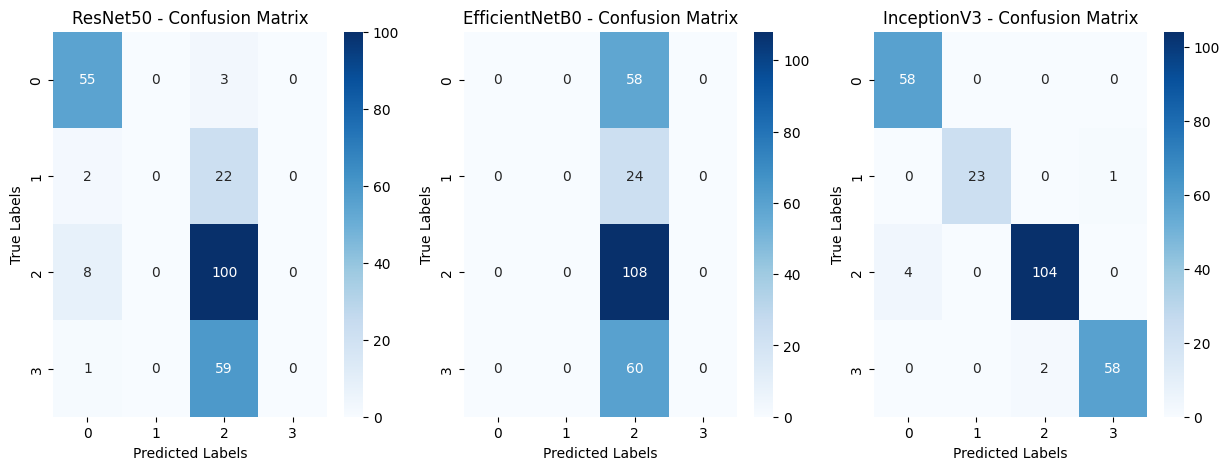

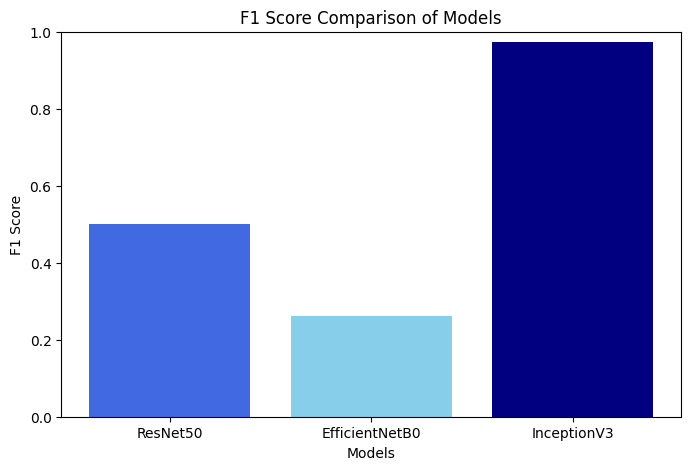


🔹 ResNet50 Performance:
✔ Precision: 0.4281
✔ Recall: 0.6200
✔ F1 Score: 0.5017

🔹 EfficientNetB0 Performance:
✔ Precision: 0.1866
✔ Recall: 0.4320
✔ F1 Score: 0.2606

🔹 InceptionV3 Performance:
✔ Precision: 0.9728
✔ Recall: 0.9720
✔ F1 Score: 0.9721


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Correct way to extract true labels (disease class, NOT scale)
y_true = val_generator_multi.image_generator.classes

# Get model predictions
y_pred_resnet = np.argmax(model_resnet.predict(val_generator_multi)[0], axis=1)
y_pred_efficientnet = np.argmax(model_efficientnet.predict(val_generator_multi)[0], axis=1)
y_pred_inception = np.argmax(model_inception.predict(val_generator_multi)[0], axis=1)

models = {
    "ResNet50": y_pred_resnet,
    "EfficientNetB0": y_pred_efficientnet,
    "InceptionV3": y_pred_inception
}

# Compute Confusion Matrices & F1-Scores
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

f1_scores = {}
precision_scores = {}
recall_scores = {}

for i, (model_name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")

    f1_scores[model_name] = f1
    precision_scores[model_name] = precision
    recall_scores[model_name] = recall

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_name} - Confusion Matrix")
    axes[i].set_xlabel("Predicted Labels")
    axes[i].set_ylabel("True Labels")

plt.show()

# Plot F1-Score Comparison
plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color=["royalblue", "skyblue", "navy"])
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison of Models")
plt.ylim(0, 1)
plt.show()

# Print Precision, Recall, and F1 Score for Each Model
for model_name in models.keys():
    print(f"\n🔹 {model_name} Performance:")
    print(f"✔ Precision: {precision_scores[model_name]:.4f}")
    print(f"✔ Recall: {recall_scores[model_name]:.4f}")
    print(f"✔ F1 Score: {f1_scores[model_name]:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step


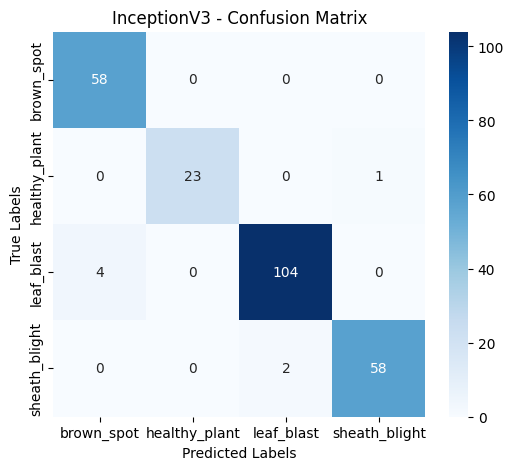

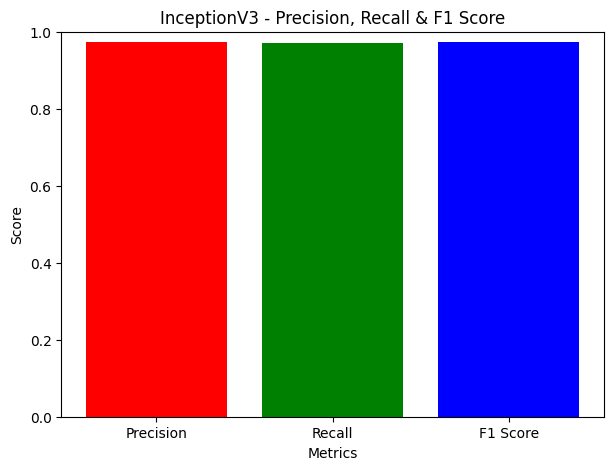


🔹 InceptionV3 Performance:
✔ Precision: 0.9728
✔ Recall: 0.9720
✔ F1 Score: 0.9721


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Extract true class labels
y_true = val_generator_multi.image_generator.classes

# Get InceptionV3 predictions
y_pred_inception = np.argmax(model_inception.predict(val_generator_multi)[0], axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred_inception)

# Compute Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred_inception, average="weighted")
recall = recall_score(y_true, y_pred_inception, average="weighted")
f1 = f1_score(y_true, y_pred_inception, average="weighted")

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.title("InceptionV3 - Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Bar Plot for Precision, Recall & F1-Score
metrics = {"Precision": precision, "Recall": recall, "F1 Score": f1}
plt.figure(figsize=(7, 5))
plt.bar(metrics.keys(), metrics.values(), color=["red", "green", "blue"])
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("InceptionV3 - Precision, Recall & F1 Score")
plt.ylim(0, 1)
plt.show()

# Print Performance Metrics
print("\n🔹 InceptionV3 Performance:")
print(f"✔ Precision: {precision:.4f}")
print(f"✔ Recall: {recall:.4f}")
print(f"✔ F1 Score: {f1:.4f}")


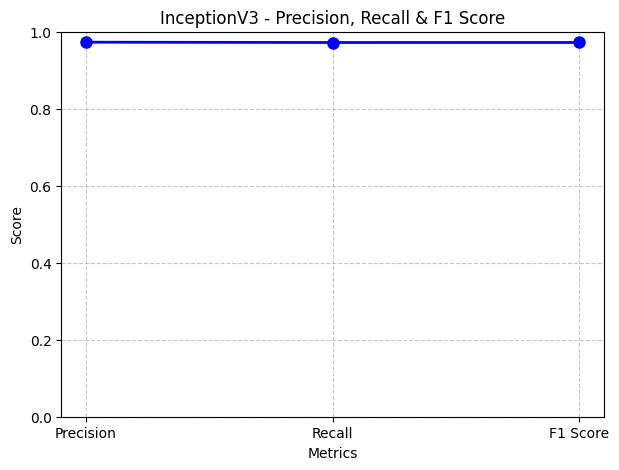

In [ ]:
# Line Plot for Precision, Recall & F1-Score
metrics = ["Precision", "Recall", "F1 Score"]
scores = [precision, recall, f1]

plt.figure(figsize=(7, 5))
plt.plot(metrics, scores, marker="o", linestyle="-", color="b", markersize=8, linewidth=2)
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("InceptionV3 - Precision, Recall & F1 Score")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
history = model_inception.fit(train_generator,
                              validation_data=val_generator,
                              epochs=20)  # Adjust epochs as needed


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [ ]:
import pickle

# Load history from a saved file (if available)
with open("model_inception.h5", "rb") as f:
    history = pickle.load(f)
 #for maintaining the old model


FileNotFoundError: [Errno 2] No such file or directory: 'model_inception.h5'

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["loss"]) + 1)

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["loss"], "r", label="Training Loss")
plt.plot(epochs, history["val_loss"], "b", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("InceptionV3 - Learning Curve (Loss)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["accuracy"], "r", label="Training Accuracy")
plt.plot(epochs, history["val_accuracy"], "b", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("InceptionV3 - Learning Curve (Accuracy)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


KeyError: 'loss'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Get the number of classes
num_classes = val_generator_multi.num_classes  # Ensure your generator has this attribute

# Get true labels
y_true = val_generator_multi.labels  # True class indices
y_true = to_categorical(y_true, num_classes=num_classes)  # Convert to one-hot encoding

# Get predicted probabilities for each class
y_pred_prob = model_inception.predict(val_generator_multi)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for InceptionV3 Model")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()


NameError: name 'val_generator_multi' is not defined